In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import date, datetime, timedelta

## Visualize COVID-19 historical data

In [2]:
from global_config import config

data_path = config.get_property('covid_fb')


In [3]:
data_path = os.path.join('data')

In [4]:
# Read confirmed cases
df_cases_raw = pd.read_csv(os.path.join(data_path,'cases.csv'))        # read csv
df_cases_raw = df_cases_raw.query(" location == 'Bogotá D.C.-Bogotá d C.' ")    # get only for Bogotá
df_cases_raw['date_time'] = pd.to_datetime(df_cases_raw['date_time'], format='%Y-%m-%d')    # converted to datetime

# Perform rolling average over data
rolling_window_size = 7     # days
date_times = df_cases_raw['date_time'].tolist()

# Get data of interest
confirmed_cases = df_cases_raw['num_cases'].rolling(window=rolling_window_size).mean().tolist()
confirmed_deaths = df_cases_raw['num_diseased'].rolling(window=rolling_window_size).mean().tolist()
confirmed_hospital = df_cases_raw['num_infected_in_hospital'].rolling(window=rolling_window_size).mean().tolist()
confirmed_house = df_cases_raw['num_infected_in_house'].rolling(window=rolling_window_size).mean().tolist()

dict_cases = dict(zip(['date_time','confirmed_cases','confirmed_deaths','confirmed_hospital','confirmed_house'],
                      [date_times,confirmed_cases,confirmed_deaths,confirmed_hospital,confirmed_house]))

df_cases = pd.DataFrame(data=dict_cases)

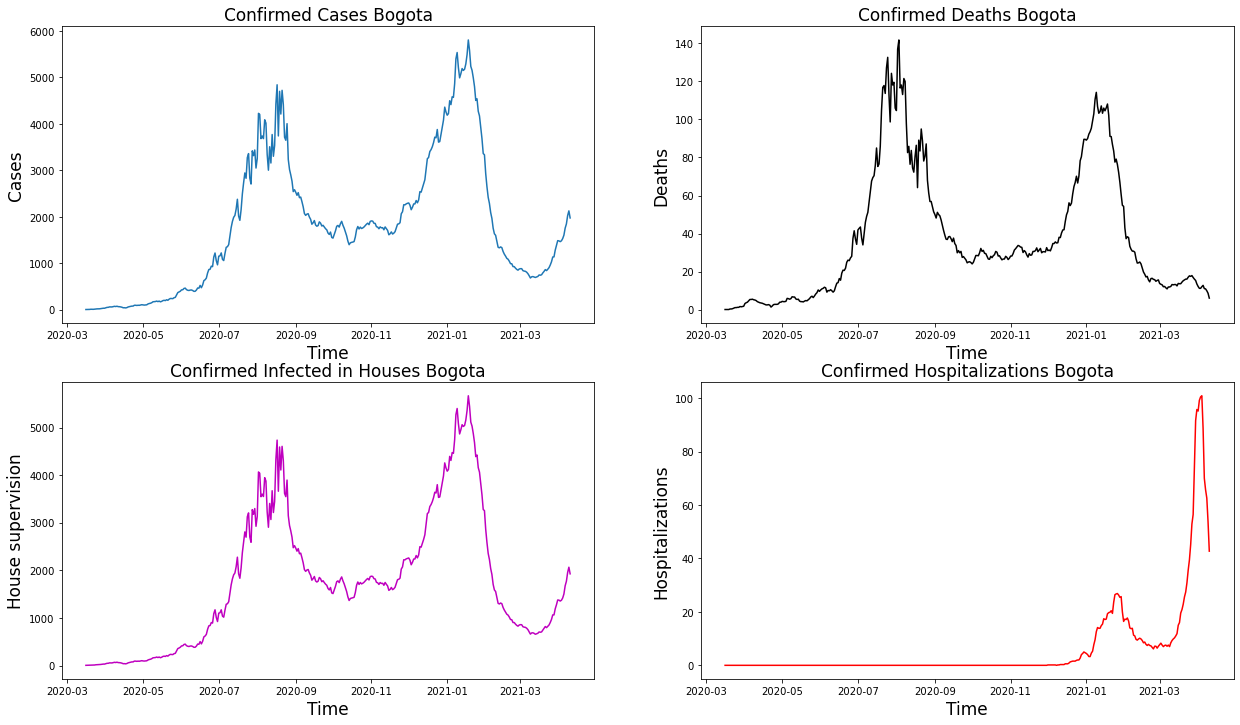

In [5]:
fig,ax = plt.subplots(2,2,figsize=(7*3, 6*2))

sns.lineplot(ax=ax[0,0], data=df_cases,x='date_time',y='confirmed_cases')
ax[0,0].set_xlabel('Time',fontsize=17)
ax[0,0].set_ylabel('Cases',fontsize=17)
ax[0,0].set_title('Confirmed Cases Bogota',fontsize=17)

sns.lineplot(ax=ax[0,1], data=df_cases,x='date_time',y='confirmed_deaths',color='k')
ax[0,1].set_xlabel('Time',fontsize=17)
ax[0,1].set_ylabel('Deaths',fontsize=17)
ax[0,1].set_title('Confirmed Deaths Bogota',fontsize=17)

sns.lineplot(ax=ax[1,0], data=df_cases,x='date_time',y='confirmed_house',color='m')
ax[1,0].set_xlabel('Time',fontsize=17)
ax[1,0].set_ylabel('House supervision',fontsize=17)
ax[1,0].set_title('Confirmed Infected in Houses Bogota',fontsize=17)

sns.lineplot(ax=ax[1,1], data=df_cases,x='date_time',y='confirmed_hospital',color='r')
ax[1,1].set_xlabel('Time',fontsize=17)
ax[1,1].set_ylabel('Hospitalizations',fontsize=17)
ax[1,1].set_title('Confirmed Hospitalizations Bogota',fontsize=17)

plt.show()

In [6]:
import numpy as np
rolling_window_size = 7     # days


df_movement_range_raw = pd.read_csv(os.path.join(data_path, 'movement_range.csv'), parse_dates=['date_time']).set_index('poly_id')
df_movement_raw       = pd.read_csv(os.path.join(data_path,'movement.csv'), parse_dates=['date_time']).set_index('start_poly_id')

df_movement_range_raw = df_movement_range_raw.loc[11001].sort_values(by='date_time')
df_movement_range_raw["7d_rolling"] = df_movement_range_raw['movement_change'].rolling(window=rolling_window_size).mean()

df_movement_range_raw["7d_rolling"].iloc[:rolling_window_size-1] = df_movement_range_raw["movement_change"].iloc[:rolling_window_size-1]


/Users/chaosdonkey06/conda/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


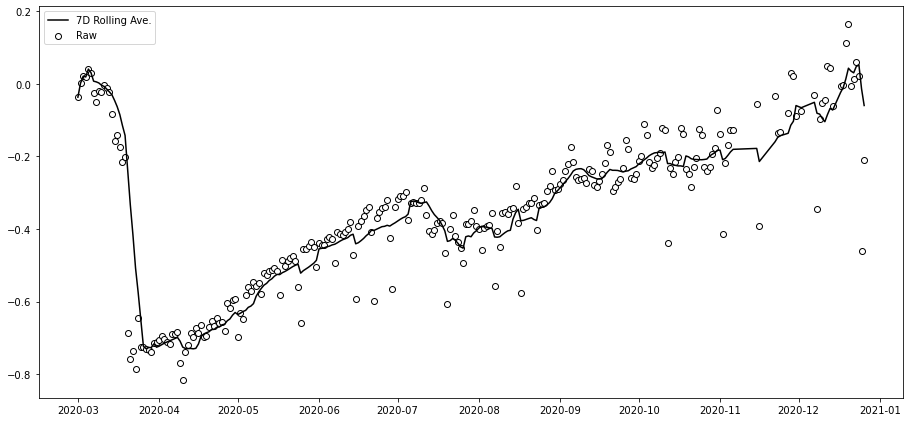

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.2))
ax.scatter(df_movement_range_raw.date_time, df_movement_range_raw["movement_change"], facecolor='w', edgecolors='k', label='Raw')
ax.plot(df_movement_range_raw.date_time, df_movement_range_raw["7d_rolling"], color='k', label='7D Rolling Ave.')

ax.legend()

## Visualize mobility patterns

In [8]:
# Read mobility data
df_movement_range_raw = df_movement_range_raw.query(" poly_id == '11001' ")    # get only for Bogotá
df_movement_range_raw['date_time'] = pd.to_datetime(df_movement_range_raw['date_time'], format='%Y-%m-%d')    # converted to datetime

df_movement_raw = df_movement_raw.query(" end_poly_id == '11001' ")    # get only for people incomming to Bogotá
df_movement_raw['date_time'] = pd.to_datetime(df_movement_raw['date_time'], format='%Y-%m-%d')    # converted to datetime

# Perform rolling average over data
rolling_window_size = 7     # days
date_times_movement_range = df_movement_range_raw['date_time'].tolist()
date_times_movement       = df_movement_raw['date_time'].tolist()

# Get data of interest
movement_range = df_movement_range_raw['movement_change'].rolling(window=rolling_window_size).mean().tolist()
movement       = df_movement_raw['movement'].rolling(window=rolling_window_size).mean().tolist()

dict_movement_range = {'date_time':date_times_movement_range,'movement_change':movement_range}
df_movement_range = pd.DataFrame(data=dict_movement_range)
dict_movement = {'date_time':date_times_movement,'movement':movement}
df_movement = pd.DataFrame(data=dict_movement)

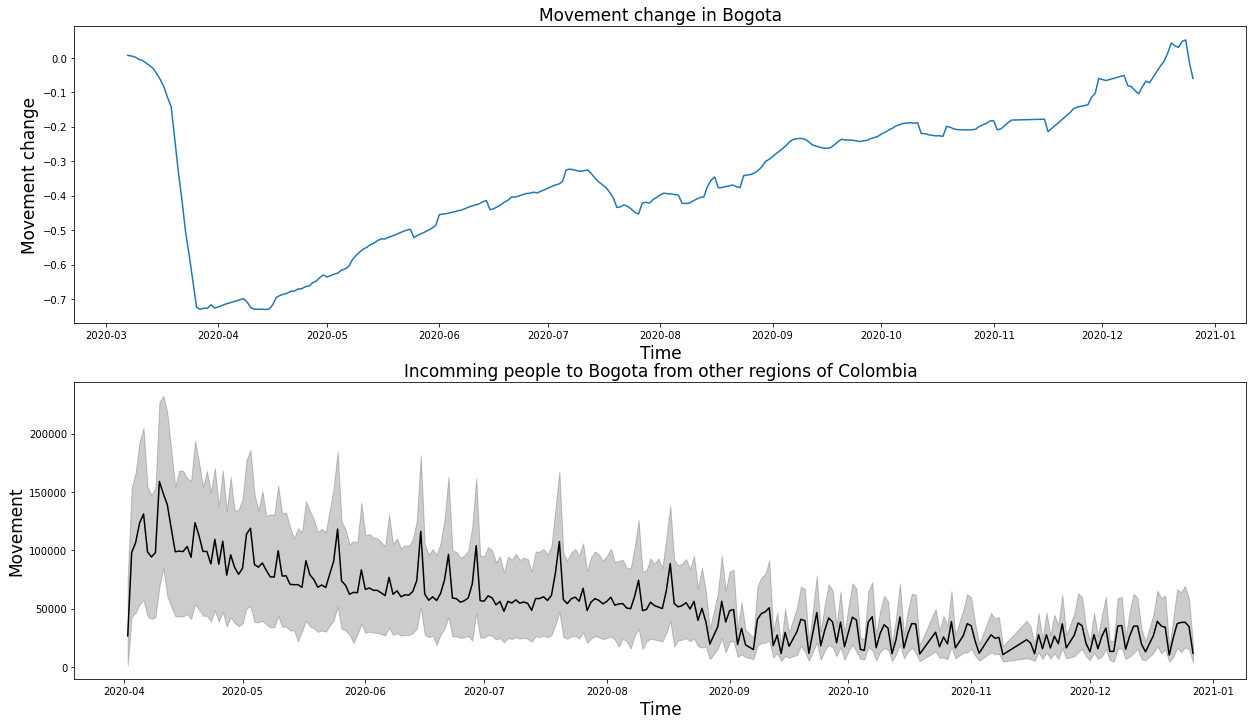

In [9]:

fig,ax = plt.subplots(2,1,figsize=(7*3, 6*2))
sns.lineplot(ax=ax[0], data=df_movement_range,x='date_time',y='movement_change')
ax[0].set_xlabel('Time',fontsize=17)
ax[0].set_ylabel('Movement change',fontsize=17)
ax[0].set_title('Movement change in Bogota',fontsize=17)

sns.lineplot(ax=ax[1], data=df_movement,x='date_time',y='movement',color='k')
ax[1].set_xlabel('Time',fontsize=17)
ax[1].set_ylabel('Movement',fontsize=17)
ax[1].set_title('Incomming people to Bogota from other regions of Colombia',fontsize=17)
plt.show()


## Visualize Google trends data
### Data corresponding to official symptoms of COVID-19, terms COVID-19-related terms with potential to track confirmed cases, and terms used to successfully track ILI activity.

In [10]:
# Import API for Google Trends
from pytrends.request import TrendReq
from pytrends import dailydata
from utils import gtrend

# Read search terms
df_search_terms   = pd.read_csv(os.path.join('data','Google_Trends','search_terms_ES.csv'))
search_terms_list = df_search_terms['term'].tolist()

### Test 'most common' keywords

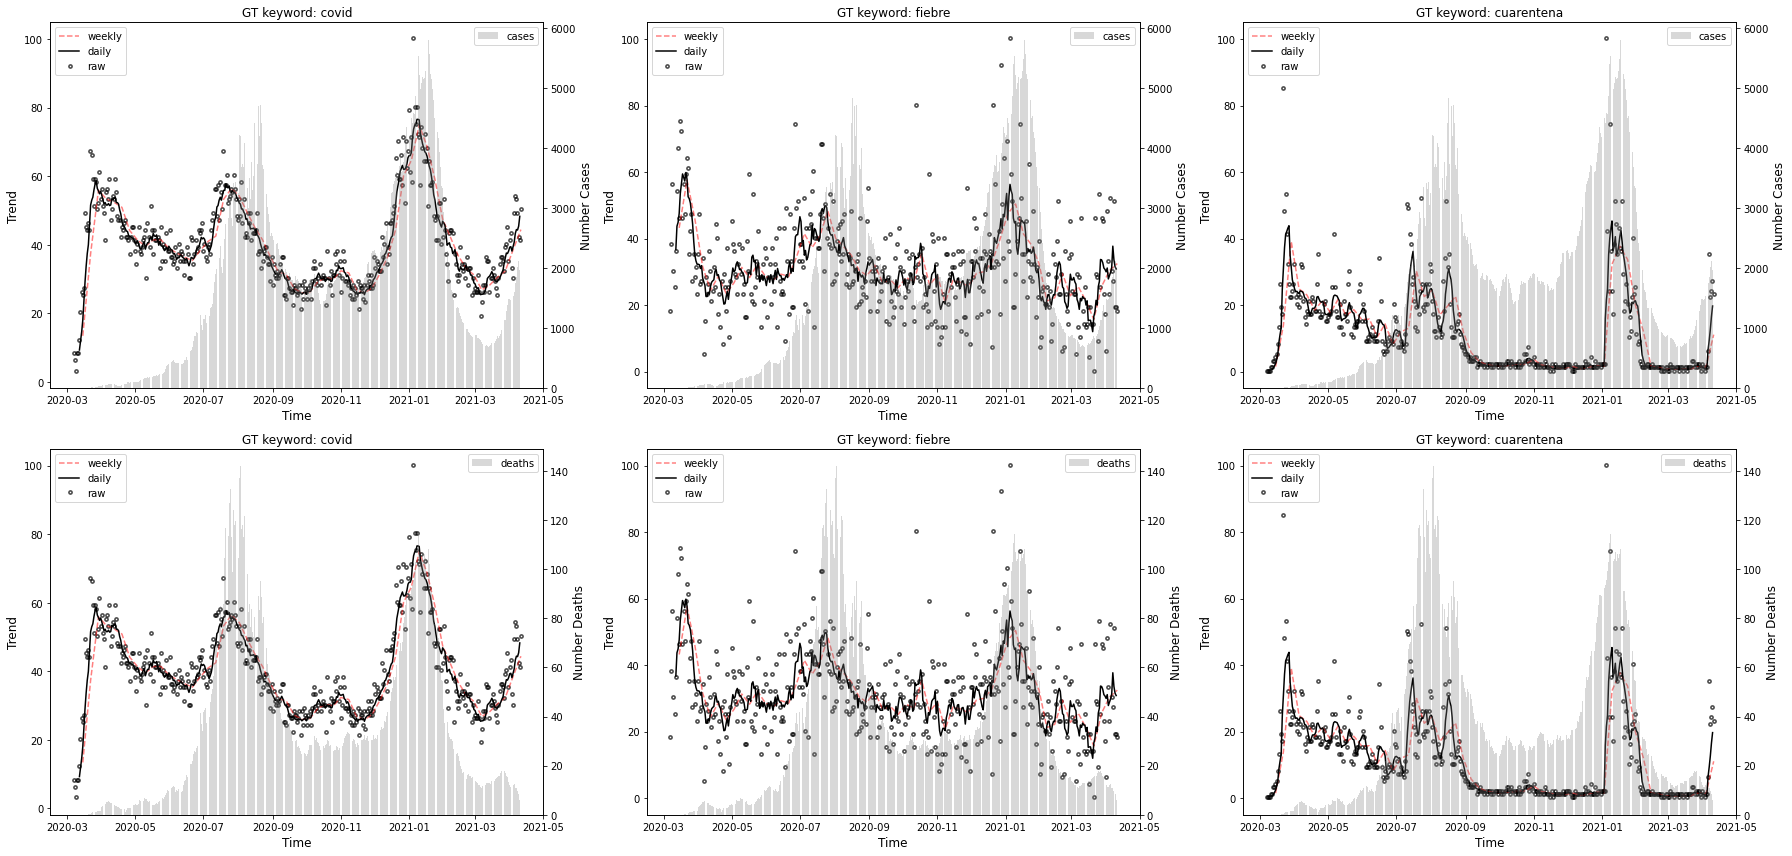

In [11]:
pytrend = TrendReq(hl='es-CO')
keywords_test = ['covid','fiebre','cuarentena']
start = '2020-03-06'
end = '2021-04-10'
geo = 'CO-DC'
cat=0
gprop=''
rolling_window_size = 7     # days

# Plot data
fig, ax = plt.subplots(2,3,figsize=(25, 12))
for i, kw in enumerate(keywords_test):
    # Read and process
    overlapping = gtrend.get_daily_trend(pytrend, kw, start, end, geo=geo, cat=cat, gprop=gprop, verbose=False)
    overlapping = overlapping.reset_index()
    overlapping["date"] = pd.to_datetime( overlapping["date"] )
    overlapping['rw'] = overlapping[kw].rolling(window=rolling_window_size).mean()
    overlapping["end_day"] = overlapping.apply(lambda x: x["date"] - timedelta(days=x['date'].weekday()) + timedelta(days=6), axis=1)
    overlapping_week = overlapping.groupby(['end_day']).mean().reset_index()
    # Plot GT
    ax[0,i].scatter(x=overlapping['date'], y=overlapping[kw], marker="$\circ$", color='k', alpha=0.5, label='raw')
    ax[0,i].plot(overlapping_week['end_day'], overlapping_week['rw'], color='r', linestyle='dashed', alpha=0.5, label='weekly')
    ax[0,i].plot(overlapping['date'], overlapping['rw'], color='k', label='daily')
    ax[0,i].legend(loc='upper left')
    ax[0,i].set_xlabel('Time',fontsize=12)
    ax[0,i].set_ylabel('Trend',fontsize=12)
    ax[0,i].set_title(f'GT keyword: {kw}',fontsize=12)
    # Plot cases
    ax1 = ax[0,i].twinx()
    ax1.bar(df_cases['date_time'], df_cases['confirmed_cases'], color='gray', alpha=0.3, label='cases')
    ax1.set_ylabel('Number Cases',fontsize=12)
    ax1.legend(loc='upper right')
    # Plot GT
    ax[1,i].scatter(x=overlapping['date'], y=overlapping[kw], marker="$\circ$", color='k', alpha=0.5, label='raw')
    ax[1,i].plot(overlapping_week['end_day'], overlapping_week['rw'], color='r', linestyle='dashed', alpha=0.5, label='weekly')
    ax[1,i].plot(overlapping['date'], overlapping['rw'], color='k', label='daily')
    ax[1,i].legend(loc='upper left')
    ax[1,i].set_xlabel('Time',fontsize=12)
    ax[1,i].set_ylabel('Trend',fontsize=12)
    ax[1,i].set_title(f'GT keyword: {kw}',fontsize=12)
    # Plot deaths
    ax2 = ax[1,i].twinx()
    ax2.bar(df_cases['date_time'], df_cases['confirmed_deaths'], color='gray', alpha=0.3, label='deaths')
    ax2.set_ylabel('Number Deaths',fontsize=12)
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Using related terms

In [12]:
# Read files containing main termss
df_main_terms = pd.read_csv(os.path.join('data','Google_Trends','terms_id_ES.csv'))

In [13]:
pytrend = TrendReq(hl='es-CO')
start = '2020-03-06'
end = '2021-04-10'
geo = 'CO-DC'
cat = 0
gprop=''

list_df_trends = []
from tqdm import tqdm
for i, row in tqdm(df_search_terms.iterrows(), total=len(search_terms_list)):
    print('Processing - ' + str(row['term']))
    get_trend = gtrend.get_daily_trend(pytrend, row['term'], start, end, geo=geo, cat=cat, gprop=gprop, verbose=False)
    get_trend = get_trend.reset_index()
    get_trend['date'] = pd.to_datetime( get_trend['date'] )
    list_df_trends.append(get_trend)

 12%|█▏        | 14/116 [00:21<02:38,  1.55s/it]
Processing - sintomas de gripa


KeyboardInterrupt: 

In [ ]:
df_trends = pd.DataFrame()
df_trends['date'] = list_df_trends[0]['date']
for i, trend in enumerate(search_terms_list):
    df_trends[trend] = list_df_trends[i][trend]
df_trends.to_csv(os.path.join(data_path,'Google_Trends','trends_BOG.csv'))

# desde acá

In [25]:
df_trends_BOG = pd.read_csv(os.path.join(data_path,'Google_Trends','trends_BOG.csv'),index_col=1)

In [26]:
df_trends_BOG_anosmia = df_trends_BOG['anosmia']
df_trends_BOG_anosmia - df_trends_BOG_anosmia.mean()/df_trends_BOG_anosmia.std

TypeError: unsupported operand type(s) for /: 'float' and 'method'

In [ ]:
df_trends_BOG

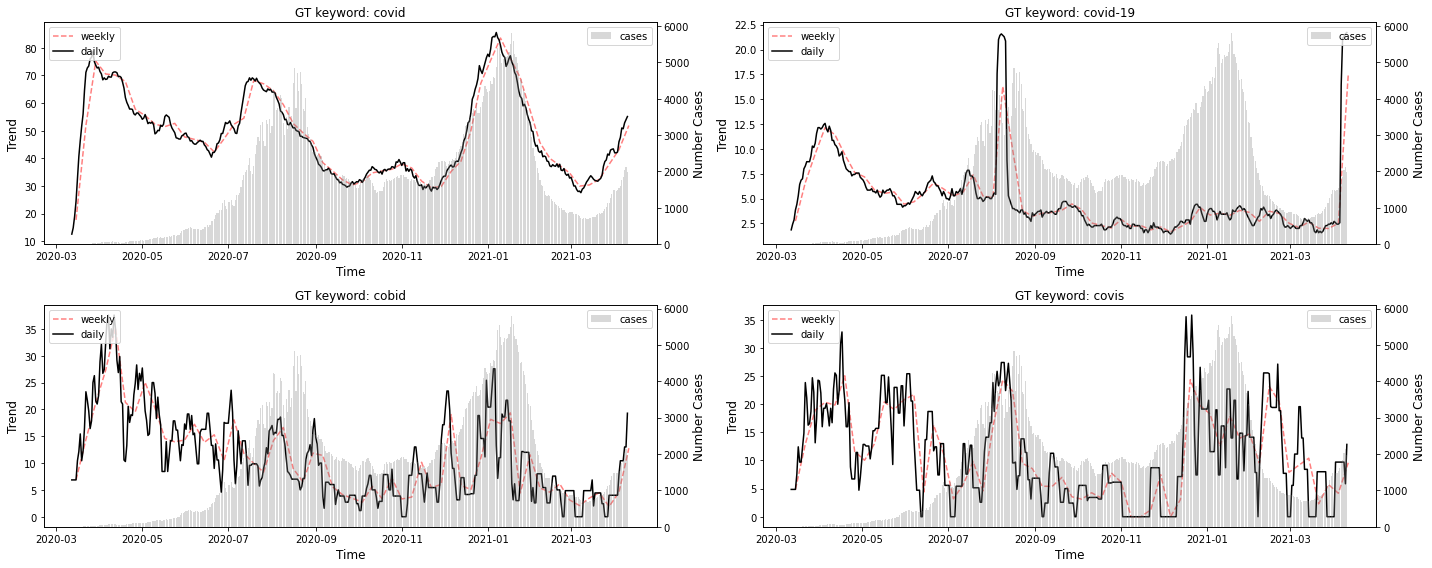

In [41]:
related_words_test = ['covid','covid-19', 'cobid','covis']
fig, ax = plt.subplots(2,2,figsize=(20, 8))
ax = ax.flatten()

df_all   = []
maximuns = []
for i, kw in enumerate(related_words_test):
    kw_trend = df_trends_BOG[kw]
    kw_trend = kw_trend.reset_index()
    kw_trend["date"]    = pd.to_datetime( kw_trend["date"] )
    # kw_trend[kw]      = (kw_trend[kw] - kw_trend[kw].min())/(kw_trend[kw].max() - kw_trend[kw].min())
    kw_trend['rw']      = kw_trend[kw].rolling(window=rolling_window_size).mean()
    #kw_trend['rw']      = (kw_trend['rw'] - kw_trend['rw'].min())/(kw_trend['rw'].max() - kw_trend['rw'].min())
    kw_trend["end_day"] = kw_trend.apply(lambda x: x["date"] - timedelta(days=x['date'].weekday()) + timedelta(days=6), axis=1)
    kw_trend_week       = kw_trend.groupby(['end_day']).mean().reset_index()
    kw_trend['term']    = [kw]*len(kw_trend)
    kw_trend = kw_trend.drop(columns=[kw])
    df_all.append(kw_trend)
        # Plot GT
    # ax[i].scatter(x=kw_trend['date'], y=kw_trend[kw], marker="$\circ$", color='k', alpha=0.5, label='raw')
    ax[i].plot(kw_trend_week['end_day'], kw_trend_week['rw'], color='r', linestyle='dashed', alpha=0.5, label='weekly')
    ax[i].plot(kw_trend['date'], kw_trend['rw'], color='k', label='daily')
    ax[i].legend(loc='upper left')
    ax[i].set_xlabel('Time',fontsize=12)
    ax[i].set_ylabel('Trend',fontsize=12)
    ax[i].set_title(f'GT keyword: {kw}',fontsize=12)
    # Plot cases
    ax1 = ax[i].twinx()
    ax1.bar(df_cases['date_time'], df_cases['confirmed_cases'], color='gray', alpha=0.3, label='cases')
    ax1.set_ylabel('Number Cases',fontsize=12)
    ax1.legend(loc='upper right')

    maximuns.append( kw_trend['rw'].max()/100 )
plt.tight_layout()
plt.show()


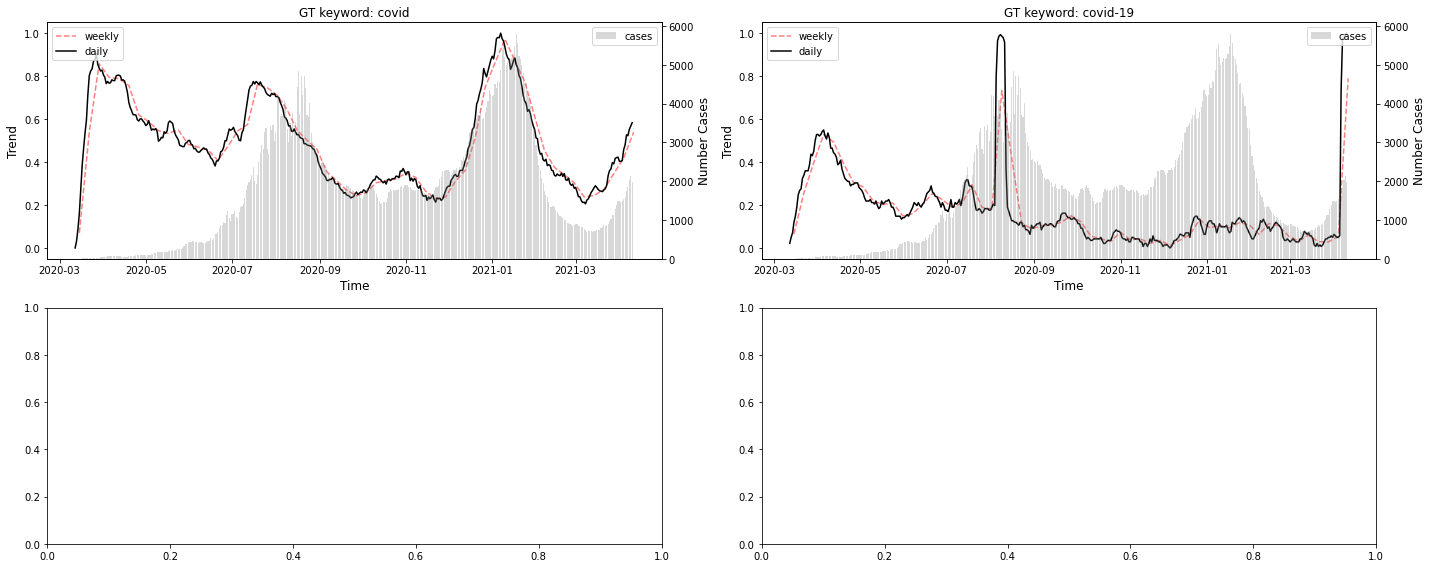

In [42]:
related_words_test = ['covid','covid-19'] #'cobid','covis'
fig, ax = plt.subplots(2,2,figsize=(20, 8))
ax = ax.flatten()

df_all = []
for i, kw in enumerate(related_words_test):
    kw_trend = df_trends_BOG[kw]
    kw_trend = kw_trend.reset_index()
    kw_trend["date"]    = pd.to_datetime( kw_trend["date"] )
    # kw_trend[kw]      = (kw_trend[kw] - kw_trend[kw].min())/(kw_trend[kw].max() - kw_trend[kw].min())
    kw_trend['rw']      = kw_trend[kw].rolling(window=rolling_window_size).mean()
    kw_trend['rw']      = (kw_trend['rw'] - kw_trend['rw'].min())/(kw_trend['rw'].max() - kw_trend['rw'].min())
    kw_trend["end_day"] = kw_trend.apply(lambda x: x["date"] - timedelta(days=x['date'].weekday()) + timedelta(days=6), axis=1)
    kw_trend_week       = kw_trend.groupby(['end_day']).mean().reset_index()
    kw_trend['term']    = [kw]*len(kw_trend)
    kw_trend = kw_trend.drop(columns=[kw])
    df_all.append(kw_trend)
        # Plot GT
    # ax[i].scatter(x=kw_trend['date'], y=kw_trend[kw], marker="$\circ$", color='k', alpha=0.5, label='raw')
    ax[i].plot(kw_trend_week['end_day'], kw_trend_week['rw'], color='r', linestyle='dashed', alpha=0.5, label='weekly')
    ax[i].plot(kw_trend['date'], kw_trend['rw'], color='k', label='daily')
    ax[i].legend(loc='upper left')
    ax[i].set_xlabel('Time',fontsize=12)
    ax[i].set_ylabel('Trend',fontsize=12)
    ax[i].set_title(f'GT keyword: {kw}',fontsize=12)
    # Plot cases
    ax1 = ax[i].twinx()
    ax1.bar(df_cases['date_time'], df_cases['confirmed_cases'], color='gray', alpha=0.3, label='cases')
    ax1.set_ylabel('Number Cases',fontsize=12)
    ax1.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [55]:
df_all = pd.concat( df_all )


TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [58]:
df_mean

,date,rw,end_day,term
6,2020-03-12,0.000000,2020-03-15,covid
7,2020-03-13,0.031311,2020-03-15,covid
8,2020-03-14,0.088063,2020-03-15,covid
9,2020-03-15,0.162427,2020-03-15,covid
10,2020-03-16,0.277886,2020-03-22,covid
...,...,...,...,...
396,2021-04-06,0.739437,2021-04-11,covid-19
397,2021-04-07,0.971831,2021-04-11,covid-19
398,2021-04-08,0.978873,2021-04-11,covid-19
399,2021-04-09,0.992958,2021-04-11,covid-19


In [61]:
len(df_mean) / 4 

197.5

In [67]:
np.unique(df_mean.term, return_counts=True)
maximuns

array([0.47351779, 0.1201581 , 0.20790514, 0.19841897])

In [68]:
import itertools
df_all = df_all.dropna()

df_mean = df_all.copy()
df_mean = df_mean.dropna()
#df_mean = df_mean.groupby(['date']).agg( rw_mean=("rw", list(maximuns) ) ).reset_index()
df_mean["weights"] = list(itertools.chain(*[[w]*(len(df_mean)//2) for w in [0.5,0.5]]))  
#df_mean            = df_mean.groupby(['date']).agg({'rw':lambda x: np.average(x['weights'], weights=x['weights'])}).unstack()
newdf = df_mean.groupby(['date']).apply(lambda x: pd.Series([ np.average(x['rw'], weights=x['weights']) ]) ).reset_index()
newdf.keys()

Index(['date', 0], dtype='object')

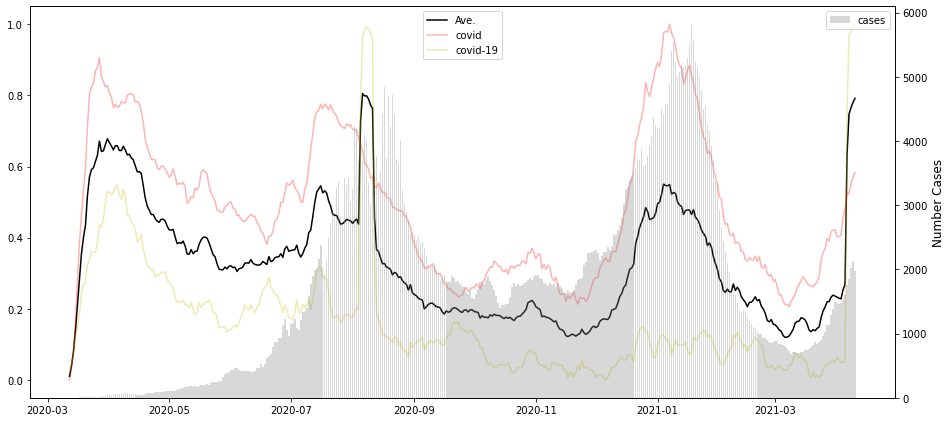

In [70]:
fig, ax = plt.subplots(1,1, figsize=(15.5, 7.2))

ax.plot(newdf["date"], newdf[0], color='k', label='Ave.')

ax.plot(newdf["date"], df_all[df_all["term"]=='covid']["rw"], color='r', label='covid', alpha=0.3)
#ax.plot(newdf["date"], df_all[df_all["term"]=='cobid']["rw"], color='g', label='cobid', alpha=0.3)
#ax.plot(newdf["date"], df_all[df_all["term"]=='covis']["rw"], color='b', label='covis', alpha=0.3)
ax.plot(newdf["date"], df_all[df_all["term"]=='covid-19']["rw"], color='y', label='covid-19', alpha=0.3)

ax.legend()

ax1 = ax.twinx()
ax1.bar(df_cases['date_time'], df_cases['confirmed_cases'], color='gray', alpha=0.3, label='cases')
ax1.set_ylabel('Number Cases',fontsize=12)
ax1.legend(loc='upper right')


# Correlation

In [71]:

def crosscorr(series1, series2, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return series2.corr(series1.shift(lag))


def compute_correlation(series2, series1, lags = list(range(10)), start_day='01-04-2020', final_day=None):

    if not start_day:
        start_day = min(series1.index.values[0], series2.index.values[0])
    if not final_day:
        final_day = min(series1.index.values[-1], series2.index.values[-1])

    min_date = pd.to_datetime(start_day, dayfirst=True)
    max_date = pd.to_datetime(final_day, dayfirst=True)

    series1 = series1.loc[start_day:max_date]
    series2 = series2.loc[start_day:max_date]

    corr_df = pd.DataFrame(columns = ['lag', 'value'])
    corr_df['lag'] = lags
    corr_df = corr_df.set_index('lag')

    for idx, lag in enumerate(lags):
        corr_df.loc[lag]['value'] = crosscorr(series1, series2, lag=lag)

    return corr_df

In [72]:
df_covid_query = df_all[df_all.term ==  'covid']
df_covid_query = df_covid_query.rename(columns={'date':'date_time'}).set_index('date_time')
df_covid_query

,rw,end_day,term
date_time,,,
2020-03-12,0.000000,2020-03-15,covid
2020-03-13,0.031311,2020-03-15,covid
2020-03-14,0.088063,2020-03-15,covid
2020-03-15,0.162427,2020-03-15,covid
2020-03-16,0.277886,2020-03-22,covid
...,...,...,...
2021-04-06,0.526419,2021-04-11,covid
2021-04-07,0.522505,2021-04-11,covid
2021-04-08,0.551859,2021-04-11,covid


In [75]:
df_covid_query

,rw,end_day,term
date_time,,,
2020-03-12,0.000000,2020-03-15,covid
2020-03-13,0.031311,2020-03-15,covid
2020-03-14,0.088063,2020-03-15,covid
2020-03-15,0.162427,2020-03-15,covid
2020-03-16,0.277886,2020-03-22,covid
...,...,...,...
2021-04-06,0.526419,2021-04-11,covid
2021-04-07,0.522505,2021-04-11,covid
2021-04-08,0.551859,2021-04-11,covid


In [76]:
df_cases

,date_time,confirmed_cases,confirmed_deaths,confirmed_hospital,confirmed_house
0,2020-03-06,NaN,NaN,NaN,NaN
1,2020-03-11,NaN,NaN,NaN,NaN
2,2020-03-12,NaN,NaN,NaN,NaN
3,2020-03-13,NaN,NaN,NaN,NaN
4,2020-03-14,NaN,NaN,NaN,NaN
...,...,...,...,...,...
392,2021-04-06,1756.428571,11.000000,70.000000,1675.285714
393,2021-04-07,1847.285714,10.857143,65.714286,1770.571429
394,2021-04-08,2027.000000,9.857143,62.571429,1954.428571
395,2021-04-09,2128.000000,8.571429,53.714286,2065.571429


In [81]:
#df_cases = df_cases.set_index('date_time')
df_merge = pd.merge(df_covid_query, df_cases, left_index=True, right_index=True)
df_merge = df_merge.dropna()

df_corr1 = compute_correlation(df_merge["confirmed_cases"], df_merge["rw"], 
                                lags = list(range(30)), start_day='15-03-2020', final_day='15-11-2020')
df_corr2 = compute_correlation(df_merge["confirmed_cases"], df_merge["rw"], 
                                lags = list(range(30)), start_day='15-03-2020', final_day=None)


Text(0.5, 1.0, 'Second Peak')

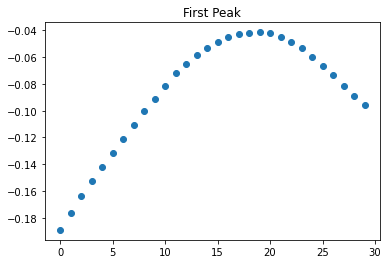

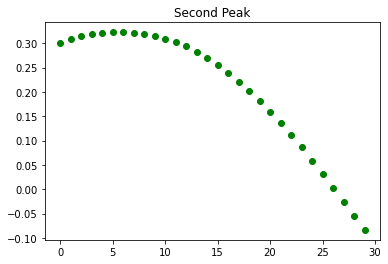

In [85]:

plt.figure()
plt.scatter(df_corr1.index.values, df_corr1.value)
plt.title('First Peak' )

plt.figure()
plt.scatter(df_corr2.index.values, df_corr2.value, color='green')
plt.title('Second Peak' )
